In [13]:
%matplotlib inline
import numpy as np
from scipy import signal
from matplotlib import pyplot as plt

from torchsummary import summary
import torch
from torch import nn, optim
from torch.autograd import Variable
import time
from time import strftime, localtime
import copy

# Datasets

Set 1: mixture of randomly generated sines and sine-gaussians within sensible parameters ranges and NO noise.

## Training

- 100 mixed signals + clean/target sources signals

In [31]:
# Parameters

T = 180     # 3 min of data, sampled every 0.1 s
fs = 10
N = T*fs
t = np.linspace(0,T,N)

# These vary..

freq_sin = np.random.uniform(0.0, 1.0, 100)                # frequency of sine wave
phase_shift_sin = np.random.uniform(0.0, 2.0*np.pi, 100)    # phase of sine wave
t0_sg = np.random.uniform(0.0, T, 100)                      # pulse starting time of sine gaussian

# These are fixed

a = 0.1
phi0 = np.pi
f0 = 0.5
tau = 10.0

In [32]:
# Time Series (needed for taking ft)

ts_s_train = np.zeros((100,N))
ts_sg_train = np.zeros((100,N))

# noise
# noise = np.random.normal(loc=0.0, scale=10.0, size=1000)

for i in range(100):
    
    ts_s_train[i,:] = a*np.sin(2*np.pi*freq_sin[i]*t + phase_shift_sin[i]) #+ noise
    ts_sg_train[i,:] = a*(np.exp(-(t-t0_sg[i])**2/tau**2))*(np.cos(2*np.pi*f0*(t-t0_sg[i])+phi0)) #+ noise
    
    ts_mix_train = ts_s_train + ts_sg_train

(100, 1800)
(100, 1800)
(100, 1800)


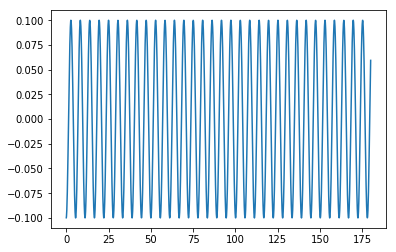

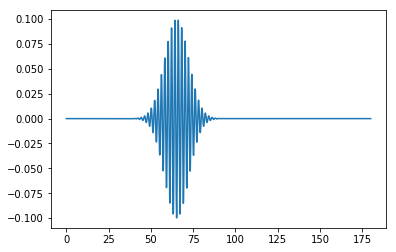

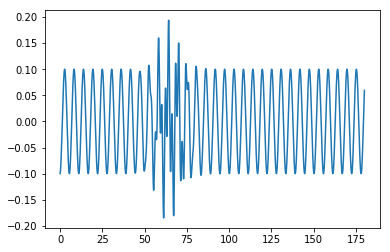

In [33]:
print(ts_s_train.shape)
print(ts_sg_train.shape)
print (ts_mix_train.shape)

# Time series examples

plt.plot(t, ts_s_train[0,:])
plt.show()
plt.plot(t, ts_sg_train[0,:])
plt.show()
plt.plot(t, ts_mix_train[0,:])
plt.show()

In [34]:
# Spectrograms

NFFT = 20*fs   # FTT time interval

NOVL = NFFT*0.7         # overlap

window = np.blackman(NFFT) 

spec_s_train = []
spec_sg_train = []
spec_mix_train = []

for i in range(100):
    
    temp1, _, _ = plt.mlab.specgram(ts_s_train[i, :], NFFT=NFFT, Fs=fs, window=window, noverlap=NOVL)
    spec_s_train.append(temp1)
    
    temp2, _, _ = plt.mlab.specgram(ts_sg_train[i, :], NFFT=NFFT, Fs=fs, window=window, noverlap=NOVL)
    spec_sg_train.append(temp2)
    
    temp3, _, _ = plt.mlab.specgram(ts_mix_train[i, :], NFFT=NFFT, Fs=fs, window=window, noverlap=NOVL)
    spec_mix_train.append(temp3)

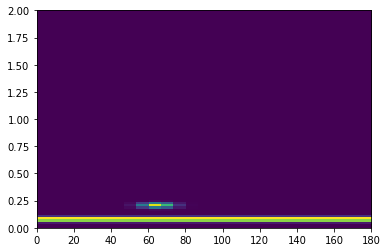

In [35]:
extent = (0.0, 180.0, 0.0, 2.0)

plt.imshow(spec_mix_train[0], aspect='auto', origin='lower', extent=extent)

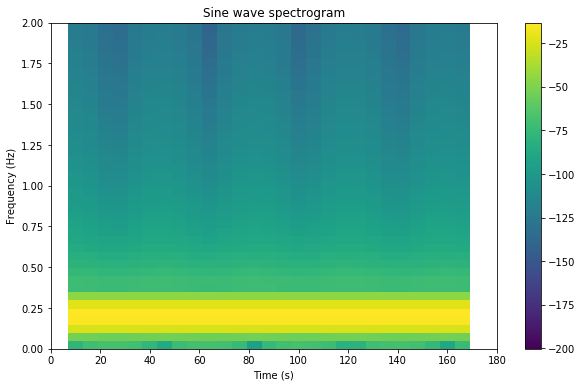

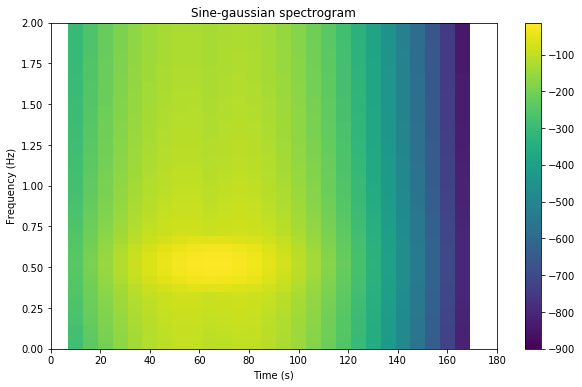

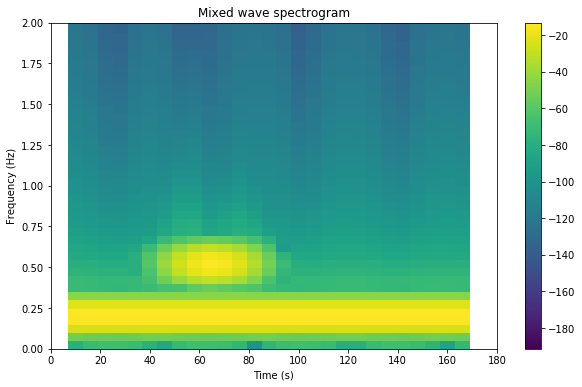

In [36]:
#Prettier spectrograms

spec_cmap='viridis'  # colormap 

# Plot the sine spectrogram:
plt.figure(figsize=(10,6))
spec_s, freqs_s, bins_s, im_s = plt.specgram(ts_s_train[0,:], NFFT=NFFT, Fs=fs, window=window, 
                                       noverlap=NOVL, cmap=spec_cmap)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar()
plt.axis([0.0, T, 0.0, 2.0])
plt.title('Sine wave spectrogram')

plt.show()

# Plot the sine-gaussian spectrogram:
plt.figure(figsize=(10,6))
spec_sg, freqs_sg, bins_sg, im_sg = plt.specgram(ts_sg_train[0,:], NFFT=NFFT, Fs=fs, window=window, 
                                       noverlap=NOVL, cmap=spec_cmap)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar()
plt.axis([0.0, T, 0.0, 2.0])
plt.title('Sine-gaussian spectrogram')

plt.show()

# Plot the mixed signal spectrogram:
plt.figure(figsize=(10,6))
spec_mix, freqs_mix, bins_mix, im_mix = plt.specgram(ts_mix_train[0,:], NFFT=NFFT, Fs=fs, window=window, 
                                       noverlap=NOVL, cmap=spec_cmap)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar()
plt.axis([0.0, T, 0.0, 2.0])
plt.title('Mixed wave spectrogram')

plt.show()

## Validation

- 20 mixed signals + clean/target sources signals

In [9]:
# Time series (needed for taking ft) 

ts_s_validation = np.zeros((20,N))
ts_sg_validation = np.zeros((20,N))

# noise
# noise = np.random.normal(loc=0.0, scale=10.0, size=1000)

for i in range(20):
    
    ts_s_validation[i,:] = a*np.sin(2*np.pi*t + phase_shift_sin[i]) #+ noise
    ts_sg_validation[i,:] = a*(np.exp(-(t-t0_sg[i])**2/tau**2))*(np.cos(2*np.pi*f0*(t-t0_sg[i])+phi0)) #+ noise
    
    ts_mix_validation = ts_s_validation + ts_sg_validation

In [10]:
# Spectrograms

spec_s_validation = []
spec_sg_validation = []
spec_mix_validation = []

for i in range(20):
    
    temp1, _, _ = plt.mlab.specgram(ts_s_validation[i, :], NFFT=NFFT, Fs=fs, window=window, noverlap=NOVL)
    spec_s_validation.append(temp1)
    
    temp2, _, _ = plt.mlab.specgram(ts_sg_validation[i, :], NFFT=NFFT, Fs=fs, window=window, noverlap=NOVL)
    spec_sg_validation.append(temp2)
    
    temp3, _, _ = plt.mlab.specgram(ts_mix_validation[i, :], NFFT=NFFT, Fs=fs, window=window, noverlap=NOVL)
    spec_mix_validation.append(temp3)

## Testing

- 100 randomly generated useen mixed signals + clean/target sources for evaluation

In [11]:
# Time series (needed for taking ft)

ts_s_test = np.zeros((100,N))
ts_sg_test = np.zeros((100,N))

# noise
# noise = np.random.normal(loc=0.0, scale=10.0, size=1000)

for i in range(100):
    
    ts_s_test[i,:] = a*np.sin(2*np.pi*t + phase_shift_sin[i]) #+ noise
    ts_sg_test[i,:] = a*(np.exp(-(t-t0_sg[i])**2/tau**2))*(np.cos(2*np.pi*f0*(t-t0_sg[i])+phi0)) #+ noise
    
    ts_mix_test = ts_s_test + ts_sg_test

In [12]:
# Spectrograms

spec_s_test = []
spec_sg_test = []
spec_mix_test = []

for i in range(100):
    
    temp1, _, _ = plt.mlab.specgram(ts_s_test[i, :], NFFT=NFFT, Fs=fs, window=window, noverlap=NOVL)
    spec_s_test.append(temp1)
    
    temp2, _, _ = plt.mlab.specgram(ts_sg_test[i, :], NFFT=NFFT, Fs=fs, window=window, noverlap=NOVL)
    spec_sg_test.append(temp2)
    
    temp3, _, _ = plt.mlab.specgram(ts_mix_test[i, :], NFFT=NFFT, Fs=fs, window=window, noverlap=NOVL)
    spec_mix_test.append(temp3)

# Model

- Architecture is the same for each source. One net per source.
- Basically a convolutional AE
- Loss function is the mean square error between the output and the clean target.
- Weights initiated randomly

# Training